# Importation des bibliothèques nécessaires
```python

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



## Nettoyage et préparation des données
Nous allons charger les données, nettoyer les colonnes inutiles et gérer les types de données incorrects.
```python

In [72]:

def clean_and_prepare_data(data):
    columns_to_drop = ['département', 'circonscription', 'Code département', 'Inscrits', 'Votants', 'Exprimés', 'Blancs et nuls']
    data = data.drop(columns=columns_to_drop)
    for col in data.columns:
        if data[col].dtype == object:
            data[col] = data[col].str.replace(',', '.').astype(float)
    return data

data = pd.read_parquet('../dataset/dataframe_politique_pouvoir_achat_chomage.parquet')
data = clean_and_prepare_data(data)


## Sélection des caractéristiques et cibles
Nous sélectionnons les variables explicatives et les cibles pour la formation des modèles.
```python

In [73]:
X = data[['Chomage', 'Pouvoir d’achat du revenu disponible brut', 'Pouvoir d\'achat par unité de consommation']]
y = data[['Extrême gauche_Pct', 'Gauche_Pct', 'Droite_Pct', 'Extrême droite_Pct']]


## Transformation des cibles en classes
Cette fonction transforme les pourcentages en classes catégoriques pour la classification.
```python

In [74]:
def transform_to_classes(y):
    bins = [0, 25, 50, 75, 100]
    labels = [0, 1, 2, 3]
    y_classes = pd.cut(y, bins=bins, labels=labels, include_lowest=True)
    return y_classes.astype(int)

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_class = y_train.apply(transform_to_classes)
y_test_class = y_test.apply(transform_to_classes)


## Entraînement du modèle RandomForest
Nous entraînons un modèle de régression et de classification RandomForest.
```python

In [75]:
# Régression
regressor = RandomForestRegressor(n_estimators=200, max_depth=3, random_state=42)
try:
    regressor.fit(X_train, y_train_class)
except Exception as e:
    print(f"Error training model: {e}")

# Classification
classifier = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)
classifier.fit(X_train, y_train_class)

RandomForestClassifier(max_depth=3, n_estimators=200, random_state=42)

In [76]:
# Perform cross-validation
scores = cross_val_score(regressor, X, y.apply(transform_to_classes), cv=5)  # Adjust cv depending on your sample size
print("Cross-validated scores:", scores)
print("Average score:", np.mean(scores))
print("Feature Importances:", regressor.feature_importances_)


Cross-validated scores: [-0.47508218 -1.07741411 -0.16511684 -0.29404722  0.02661772]
Average score: -0.3970085276041667
Feature Importances: [0.31731246 0.31074731 0.37194023]


## Prédiction et évaluation du modèle
Nous évaluons le modèle en utilisant l'erreur quadratique moyenne pour la régression et la précision pour la classification.
```python

In [77]:
# Régression
y_pred_regressor = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred_regressor)
print(f'MSE: {mse}')

# Classification
probabilities = classifier.predict_proba(X_test)
print(probabilities)



MSE: 805.6915463892
[array([[0.80333333, 0.19666667],
       [0.83      , 0.17      ],
       [0.80833333, 0.19166667]]), array([[0.03      , 0.67916667, 0.29083333],
       [0.62166667, 0.29      , 0.08833333],
       [0.03      , 0.69916667, 0.27083333]]), array([[0.17916667, 0.745     , 0.07583333],
       [0.17      , 0.09333333, 0.73666667],
       [0.17416667, 0.75      , 0.07583333]]), array([[0.76875, 0.23125],
       [0.995  , 0.005  ],
       [0.80875, 0.19125]])]


# Calcul de l'accuracy

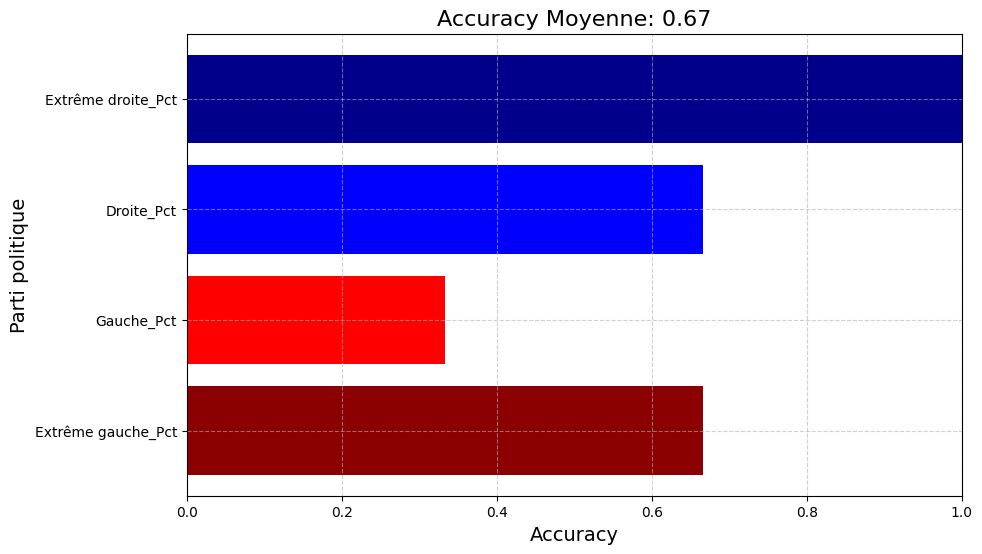

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Données simulées pour l'exemple
y_pred_class = classifier.predict(X_test)

# Utilisation de .iloc pour indexer avec des entiers
accuracies = [accuracy_score(y_test_class.iloc[:, i], y_pred_class[:, i]) for i in range(y_test_class.shape[1])]
overall_accuracy = np.mean(accuracies)

# Préparation des données pour le graphique
class_accuracies = pd.DataFrame({
    'Parti politique': y_test_class.columns,  # Assurez-vous que c'est y_test_class pour correspondre aux noms de colonne corrects
    'Accuracy': accuracies,
    'Color': ['darkred', 'red', 'blue', 'darkblue']  # Couleurs spécifiques pour chaque parti
})

# Création du graphique
plt.figure(figsize=(10, 6))
bars = plt.barh(class_accuracies['Parti politique'], class_accuracies['Accuracy'], color=class_accuracies['Color'])
plt.title(f'Accuracy Moyenne: {overall_accuracy:.2f}', fontsize=16)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Parti politique', fontsize=14)
plt.xlim(0, 1)  # Ajuster selon le maximum d'accuracy possible
plt.grid(True, linestyle='--', alpha=0.6)

# Afficher le graphique
plt.show()


## Affichage de l'importance des caractéristiques
Nous visualisons l'importance des caractéristiques pour comprendre quelles variables contribuent le plus à la prédiction du modèle.
```python


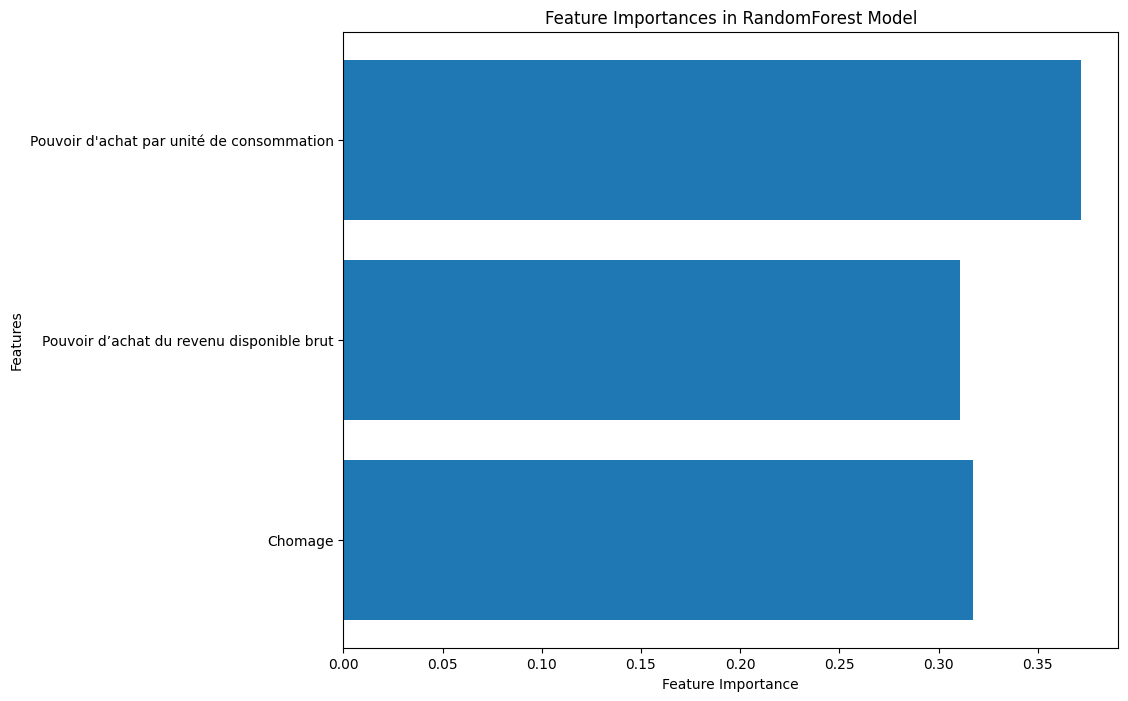

In [79]:
feature_importances = regressor.feature_importances_

plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(np.arange(len(X_train.columns)), X_train.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances in RandomForest Model')
plt.show()


## Initialisation des Partis et Couleurs
Nous commençons par définir les noms des partis politiques et associons chaque parti à une couleur spécifique pour la visualisation. Ceci est utilisé plus loin dans le code pour maintenir une cohérence visuelle dans les graphiques.

In [80]:
parties = ['Extrême gauche', 'Gauche', 'Droite', 'Extrême droite']
parties_colors = {'Extrême gauche': 'red', 'Gauche': 'green', 'Droite': 'blue', 'Extrême droite': 'purple'}


## Calcul du Nombre Maximum de Classes
Avant de calculer les probabilités moyennes, nous déterminons le nombre maximum de classes existant dans les probabilités prédites. Ceci est nécessaire pour standardiser les calculs ultérieurs sur toutes les listes de probabilités.

In [81]:
max_num_classes = max(len(party_probs[0]) for party_probs in probabilities)

## Calcul des Probabilités Moyennes
Pour chaque parti, nous calculons la probabilité moyenne pour chaque classe de pourcentage. Nous utilisons une liste de compréhension pour traiter chaque classe et chaque probabilité, s'assurant que si une classe n'est pas présente, elle soit comptée comme zéro pour éviter des erreurs de calcul.

In [82]:
mean_probabilities = []
for party_probs in probabilities:
    party_mean_probs = [
        np.mean([proba[class_idx] if class_idx < len(proba) else 0 for proba in party_probs]) 
        for class_idx in range(max_num_classes)
    ]
    mean_probabilities.append(party_mean_probs)

## Ajustement des Étiquettes des Classes
En fonction du nombre maximum de classes déterminé précédemment, nous ajustons les étiquettes des classes pour s'assurer qu'elles correspondent aux données actuelles.

In [83]:
adjusted_classes = ['0-25%', '25-50%', '50-75%', '75-100%'][:max_num_classes]

## Création des Graphiques pour Chaque Classe de Pourcentage
Pour chaque classe de pourcentage, nous créons un graphique à barres qui montre la probabilité moyenne pour chaque parti. Nous utilisons les couleurs prédéfinies pour chaque parti pour améliorer la lisibilité du graphique.

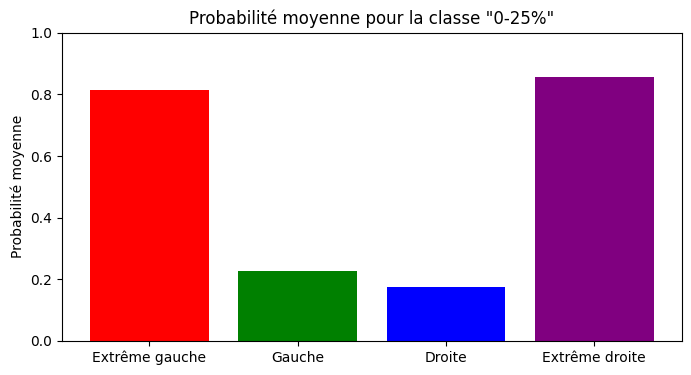

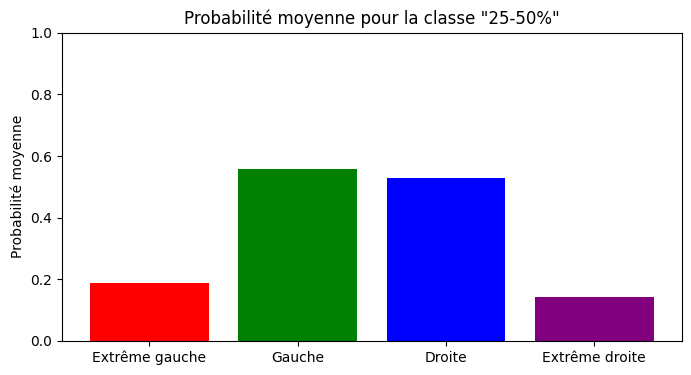

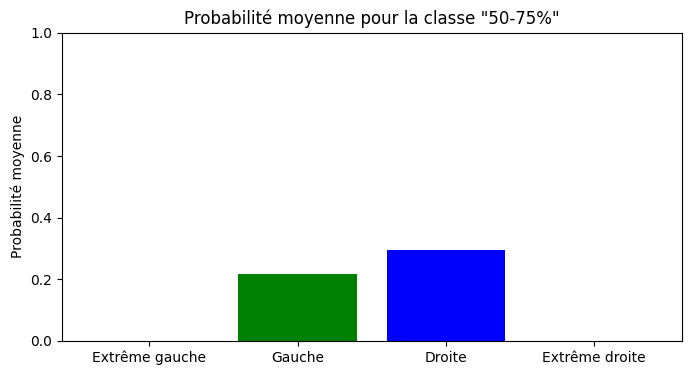

In [84]:
for class_idx, class_label in enumerate(adjusted_classes):
    plt.figure(figsize=(8, 4))
    for i, party in enumerate(parties):
        plt.bar(party, mean_probabilities[i][class_idx], color=parties_colors[party])
    
    plt.title(f'Probabilité moyenne pour la classe "{class_label}"')
    plt.ylabel('Probabilité moyenne')
    plt.ylim(0, 1)
    plt.show()


In [85]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

party_models = {}
party_predictions = {}
party_mse = {}

for party in ['Extrême gauche_Pct', 'Gauche_Pct', 'Droite_Pct', 'Extrême droite_Pct']:
    # Training a model for each party
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train[party])
    predictions = model.predict(X_test)
    
    # Storing the model and predictions
    party_models[party] = model
    party_predictions[party] = predictions
    
    # Evaluate the model
    mse = mean_squared_error(y_test[party], predictions)
    party_mse[party] = mse
    print(f'MSE for {party}: {mse}')


MSE for Extrême gauche_Pct: 225.7813357609739
MSE for Gauche_Pct: 557.3880081524186
MSE for Droite_Pct: 237.79198968644593
MSE for Extrême droite_Pct: 78.23146736903638


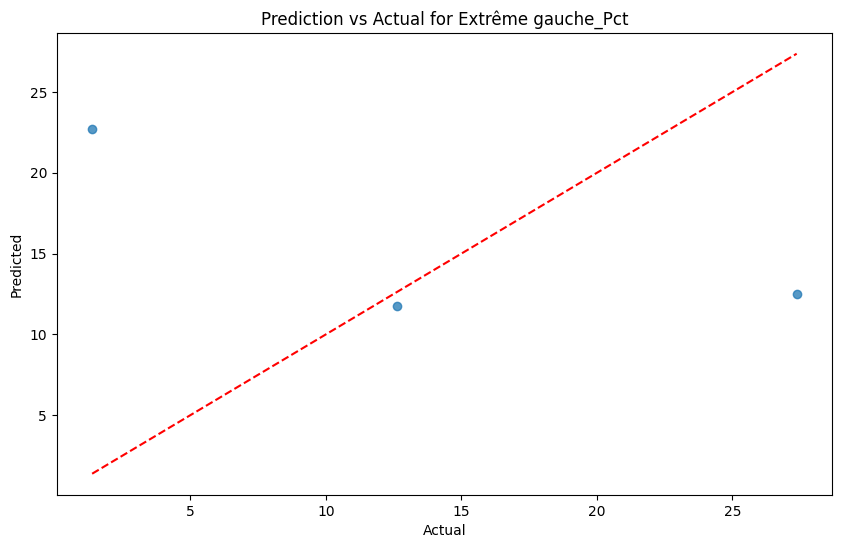

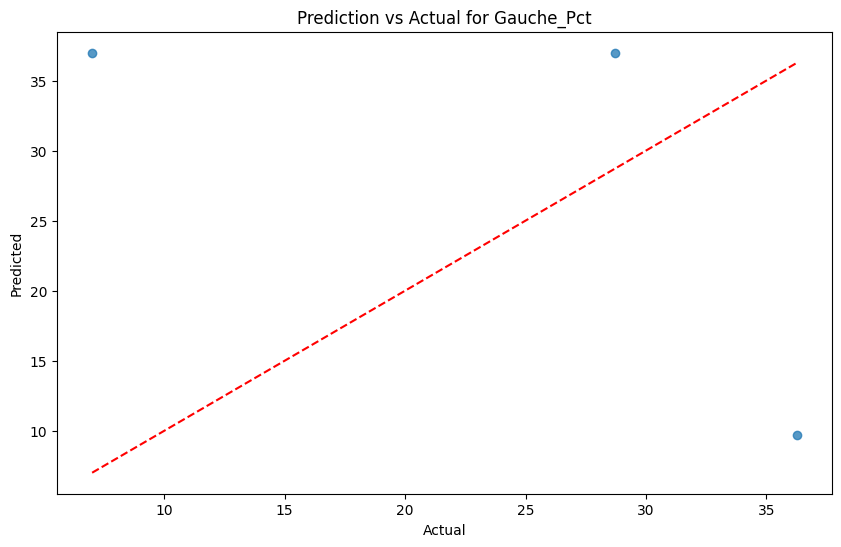

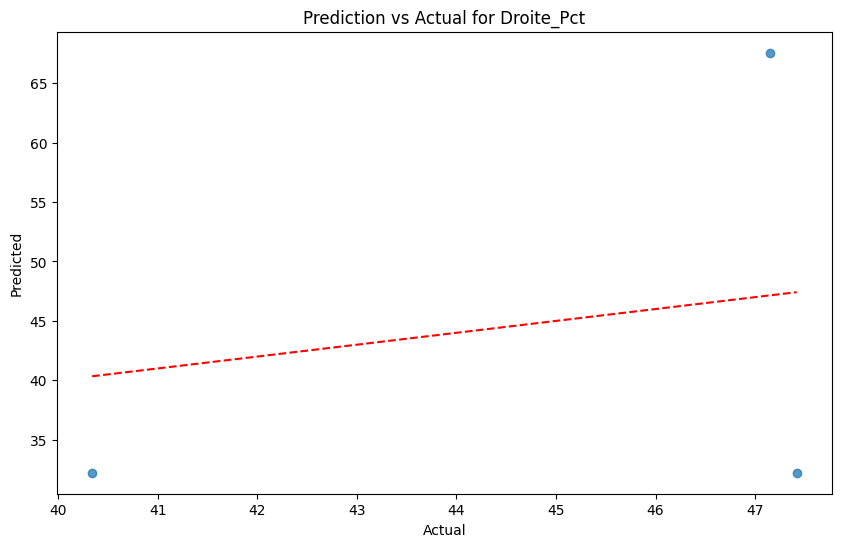

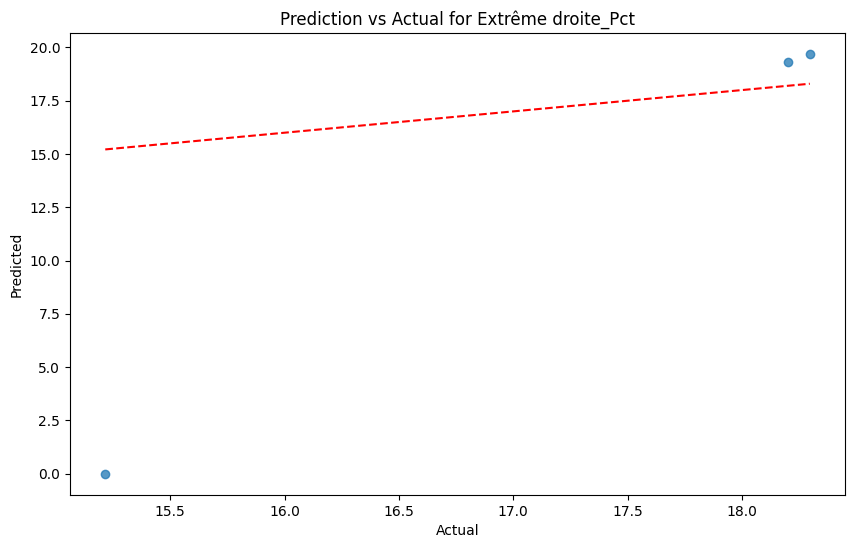

In [86]:
import matplotlib.pyplot as plt

for party in ['Extrême gauche_Pct', 'Gauche_Pct', 'Droite_Pct', 'Extrême droite_Pct']:
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test[party], party_predictions[party], alpha=0.75)
    plt.plot([y_test[party].min(), y_test[party].max()], [y_test[party].min(), y_test[party].max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Prediction vs Actual for {party}')
    plt.show()


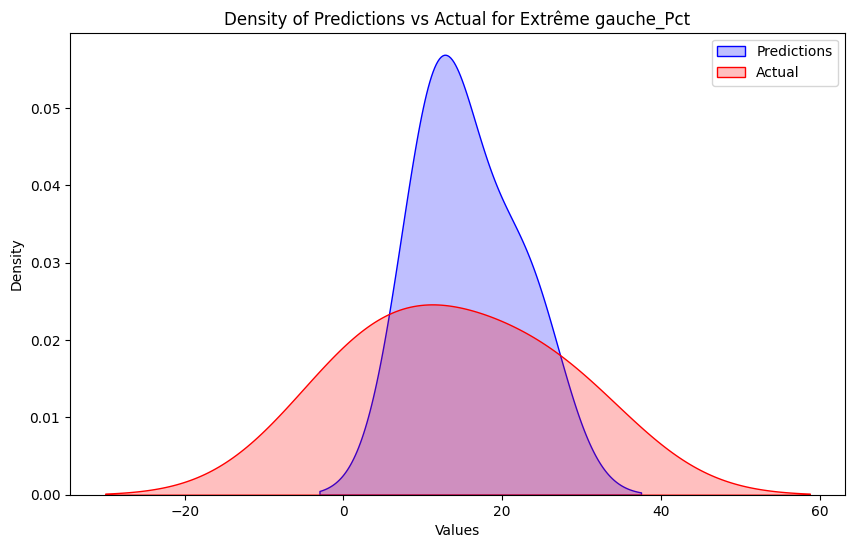

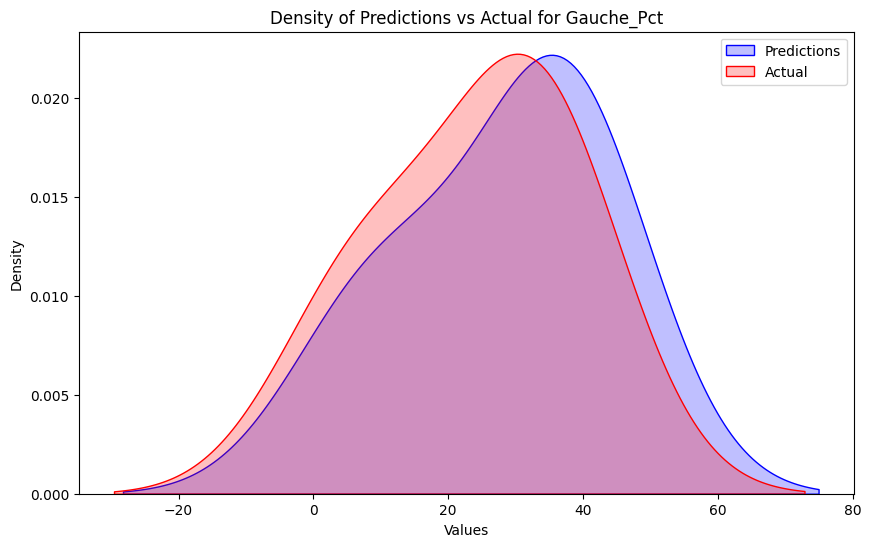

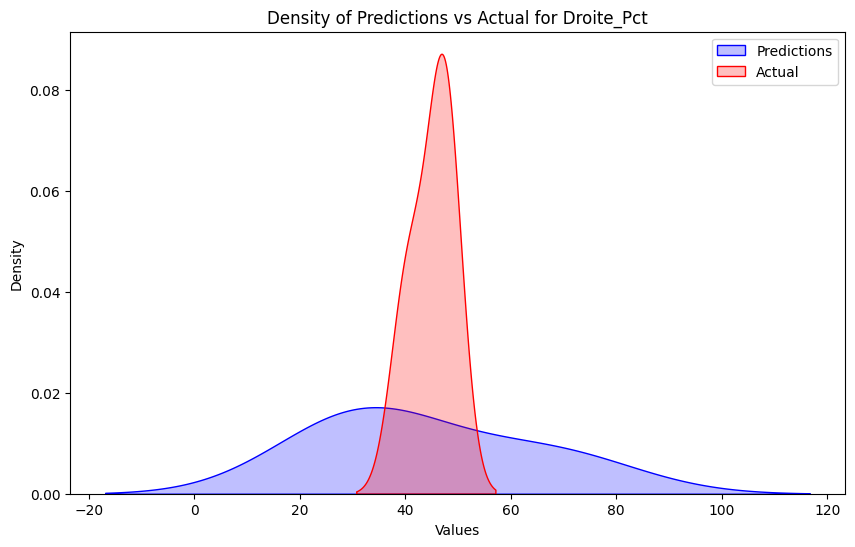

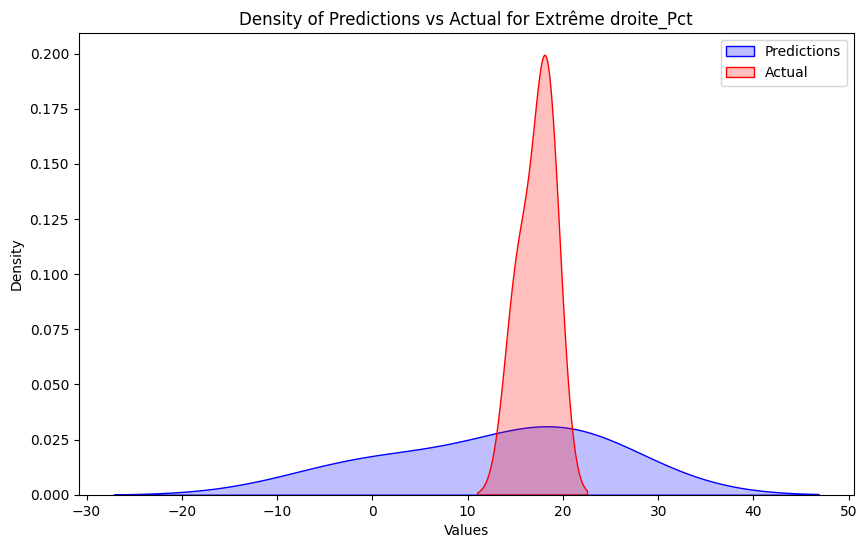

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

for party in ['Extrême gauche_Pct', 'Gauche_Pct', 'Droite_Pct', 'Extrême droite_Pct']:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(party_predictions[party], label='Predictions', color='blue', fill=True)
    sns.kdeplot(y_test[party], label='Actual', color='red', fill=True)
    plt.title(f'Density of Predictions vs Actual for {party}')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.legend()
    plt.show()




c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:1776: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 4 instead of 5.
  warnings.warn(


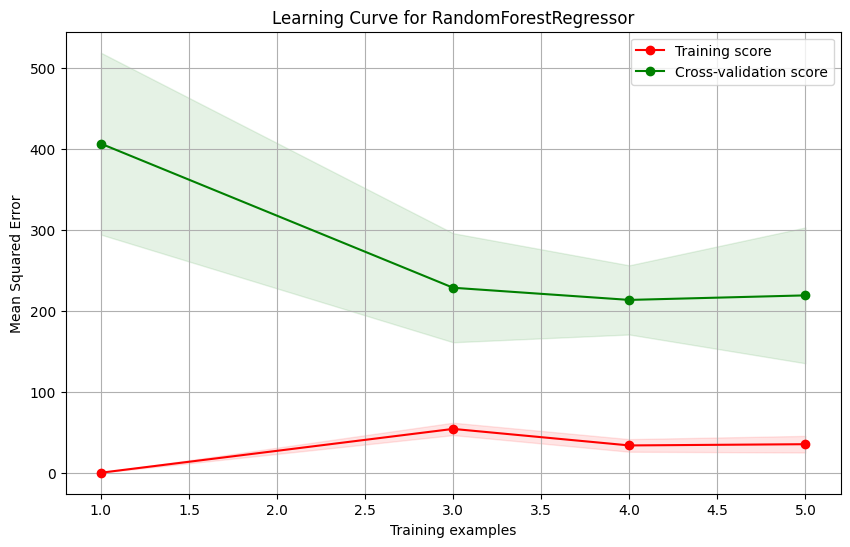

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Assumant que X_train et y_train sont déjà définis et appropriés pour la régression
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestRegressor(),  # Vous pouvez configurer le modèle ici si nécessaire
    X_train,
    y_train,
    cv=5,  # Validation croisée en 5 plis
    scoring='neg_mean_squared_error',  # Le scoring MSE négatif est courant en régression
    n_jobs=-1,  # Utiliser tous les processeurs disponibles
    train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9]  # Pourcentages de données utilisées pour l'entraînement
)

# Calcul des moyennes et des écarts-types, convertir les scores en positif pour une meilleure interprétation
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Affichage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)
plt.title('Learning Curve for RandomForestRegressor')
plt.xlabel('Training examples')
plt.ylabel('Mean Squared Error')  # Afficher MSE positif pour une interprétation correcte
plt.legend(loc="best")
plt.grid(True)
plt.show()


# Recherche des meilleurs paramètre pour notre randomForest

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Définition des paramètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],  # Test avec 100, 200, 300 arbres
    'max_depth': [None, 10, 20, 30]  # Test sans limite, 10, 20, 30 niveaux de profondeur
}

# Création du modèle pour la recherche sur grille
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres:", grid_search.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Meilleurs paramètres: {'max_depth': None, 'n_estimators': 100}


# Importance des paramètre Encore une fois

MSE: 175.26239098861058
Importance des caractéristiques:
Pouvoir d'achat par unité de consommation: 0.3543
Chomage: 0.3411
Pouvoir d’achat du revenu disponible brut: 0.3046


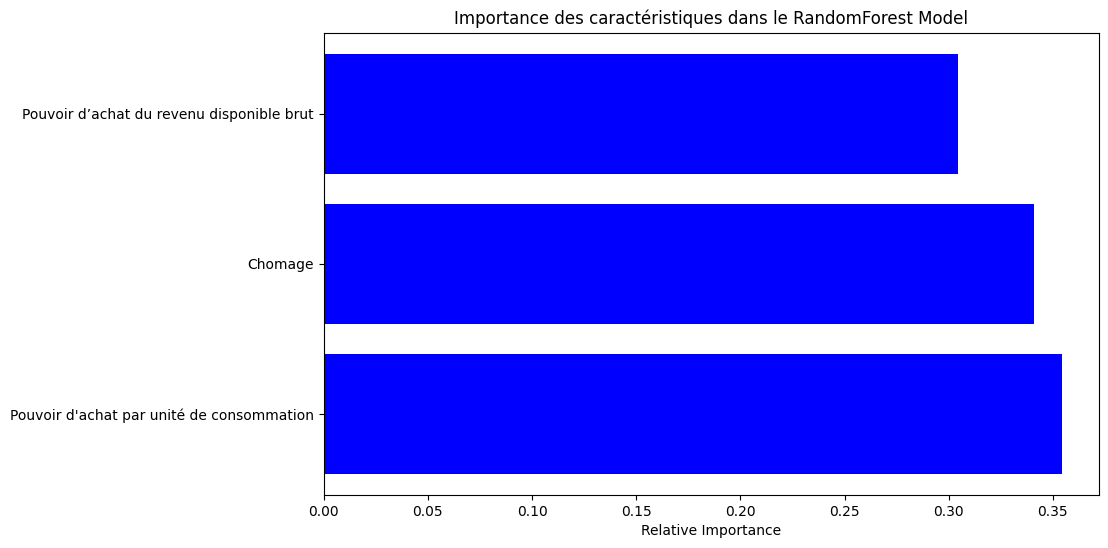

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Configuration du modèle RandomForest avec les paramètres optimisés
regressor = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)

# Entraînement du modèle
regressor.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = regressor.predict(X_test)

# Calcul de l'erreur quadratique moyenne (MSE) pour évaluer les performances
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

# Affichage de l'importance des caractéristiques
importances = regressor.feature_importances_
indices = np.argsort(importances)[::-1]

# Afficher l'importance de chaque caractéristique
print("Importance des caractéristiques:")
for i in indices:
    print(f"{X_train.columns[i]}: {importances[i]:.4f}")

# Graphique de l'importance des caractéristiques
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title('Importance des caractéristiques dans le RandomForest Model')
plt.barh(range(len(importances)), importances[indices], color='b', align='center')
plt.yticks(range(len(importances)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


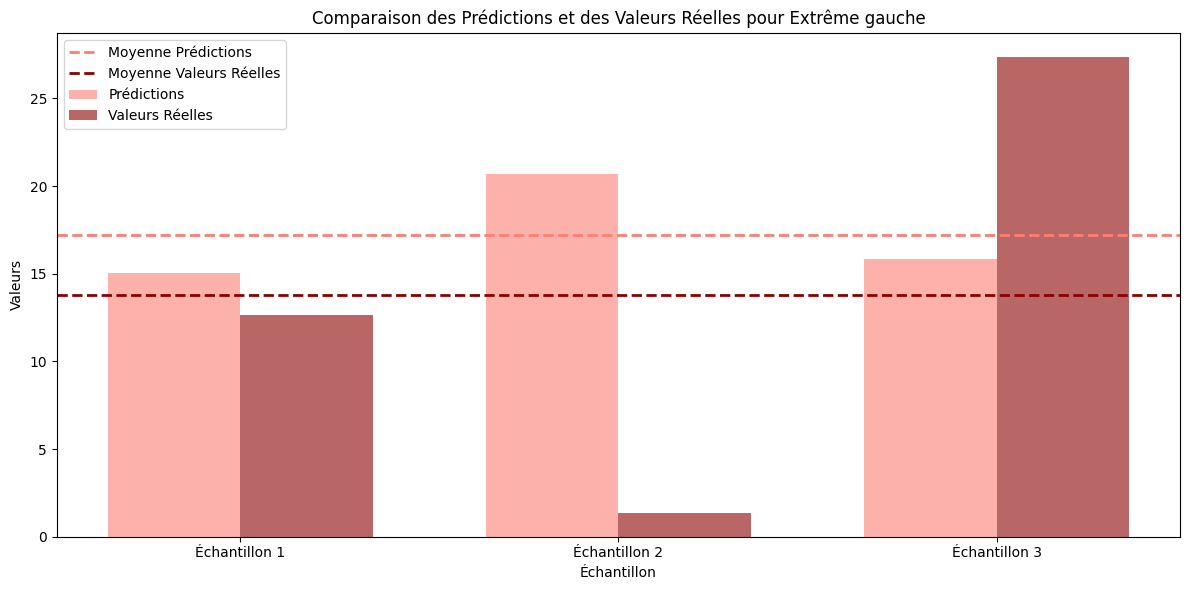

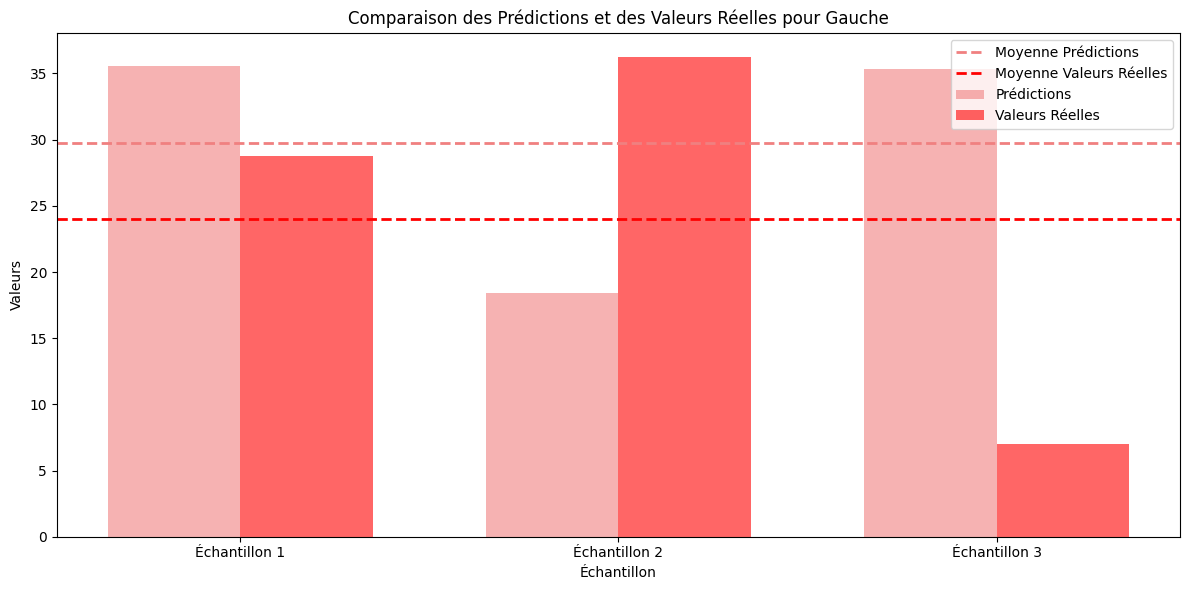

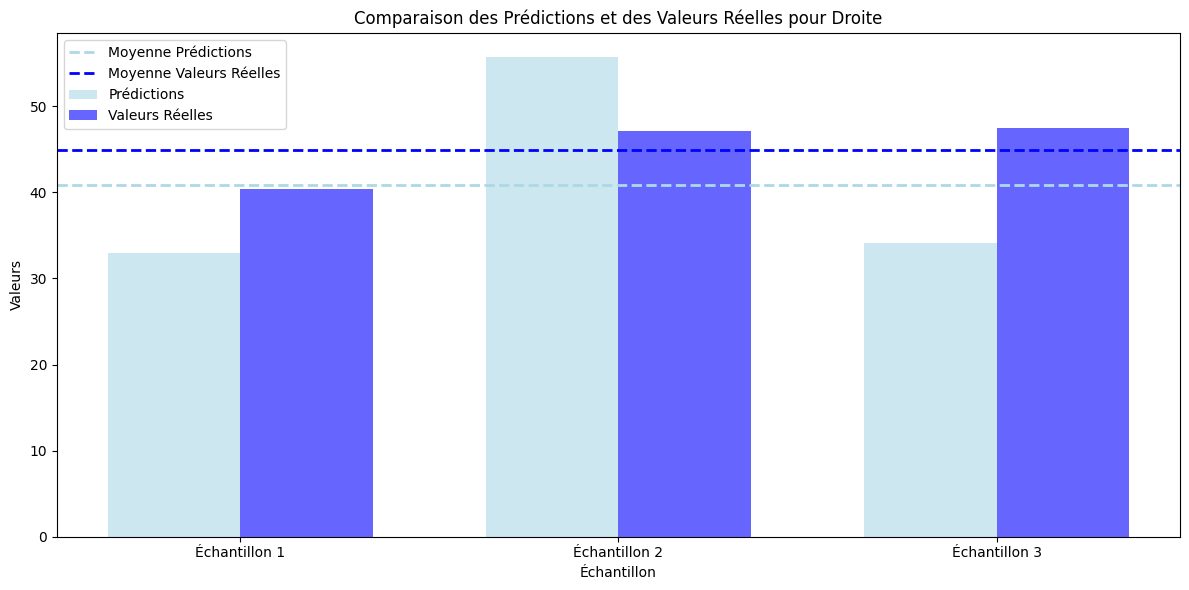

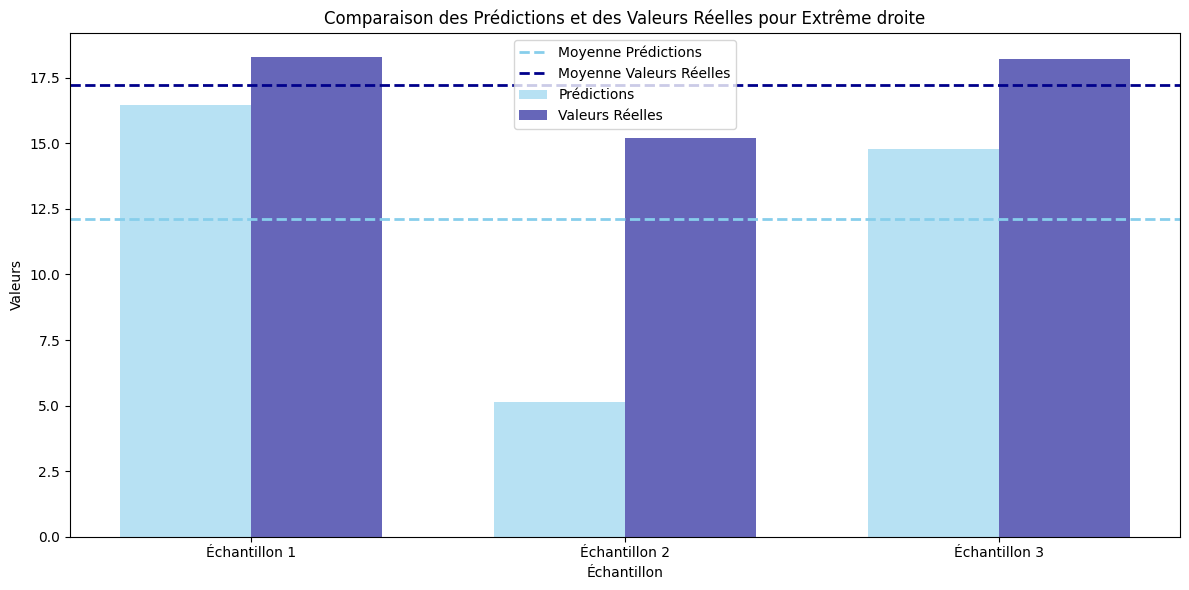

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Noms des partis politiques correspondant à chaque colonne dans y_pred et y_test
partis_politiques = ["Extrême gauche", "Gauche", "Droite", "Extrême droite"]

# Couleurs spécifiques pour chaque parti politique
colors = {
    'Extrême gauche': ('darkred', 'salmon'),  # darkred pour les valeurs réelles, salmon pour les prédictions
    'Gauche': ('red', 'lightcoral'),          # red pour les valeurs réelles, lightcoral pour les prédictions
    'Droite': ('blue', 'lightblue'),          # blue pour les valeurs réelles, lightblue pour les prédictions
    'Extrême droite': ('darkblue', 'skyblue') # darkblue pour les valeurs réelles, skyblue pour les prédictions
}

# Assurez-vous que y_pred et y_test sont des tableaux numpy
y_pred = np.array(y_pred)
y_test = np.array(y_test)

# Déterminer le nombre d'échantillons à afficher, en s'assurant de ne pas dépasser la taille des données
n_samples = min(5, y_pred.shape[0])

# Générer un graphique pour chaque parti politique
for i in range(y_pred.shape[1]):
    plt.figure(figsize=(12, 6))
    
    # Indices pour les barres
    index = np.arange(n_samples)
    bar_width = 0.35
    
    # Création des barres avec les couleurs spécifiées
    bars1 = plt.bar(index, y_pred[:n_samples, i], bar_width, label='Prédictions', alpha=0.6, color=colors[partis_politiques[i]][1])
    bars2 = plt.bar(index + bar_width, y_test[:n_samples, i], bar_width, label='Valeurs Réelles', alpha=0.6, color=colors[partis_politiques[i]][0])
    
    # Calcul des moyennes pour les prédictions et les valeurs réelles
    mean_pred = np.mean(y_pred[:, i])
    mean_real = np.mean(y_test[:, i])

    # Tracer les lignes de moyenne
    plt.axhline(y=mean_pred, color=colors[partis_politiques[i]][1], linestyle='--', linewidth=2, label='Moyenne Prédictions')
    plt.axhline(y=mean_real, color=colors[partis_politiques[i]][0], linestyle='--', linewidth=2, label='Moyenne Valeurs Réelles')
    
    plt.xlabel('Échantillon')
    plt.ylabel('Valeurs')
    plt.title(f'Comparaison des Prédictions et des Valeurs Réelles pour {partis_politiques[i]}')
    plt.xticks(index + bar_width / 2, [f'Échantillon {j+1}' for j in range(n_samples)])  # Étiquettes sous les barres
    plt.legend()
    
    plt.tight_layout()
    plt.show()


c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:1776: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 6 instead of 10.
  warnings.warn(


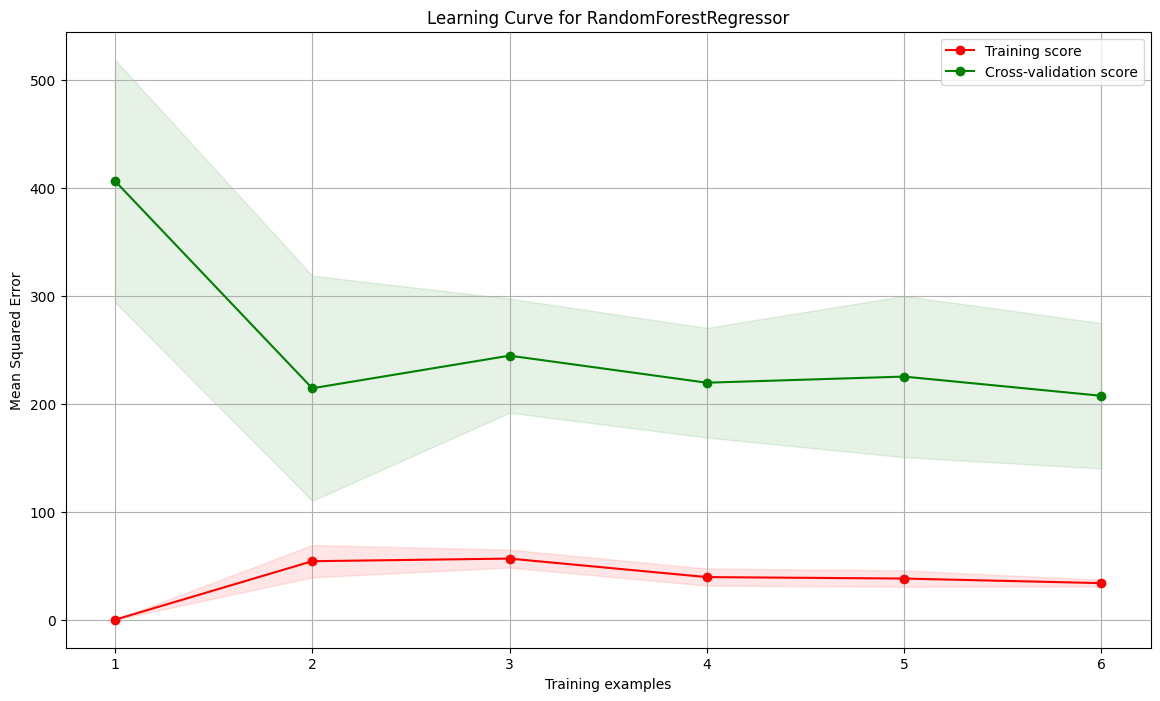

In [92]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Assumant que X_train et y_train sont déjà définis et appropriés pour la régression
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestRegressor(),  # Configuration du modèle
    X_train,
    y_train,
    cv=5,  # Validation croisée en 5 plis
    scoring='neg_mean_squared_error',  # Scoring MSE négatif
    n_jobs=-1,  # Utiliser tous les processeurs disponibles
    train_sizes=np.linspace(0.1, 1.0, 10)  # Utiliser des intervalles plus précis
)

# Calcul des moyennes et des écarts-types, conversion des scores en positif pour une meilleure interprétation
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Affichage avec une taille de graphique augmentée
plt.figure(figsize=(14, 8))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)
plt.title('Learning Curve for RandomForestRegressor')
plt.xlabel('Training examples')
plt.ylabel('Mean Squared Error')
plt.legend(loc="best")
plt.grid(True)
plt.show()


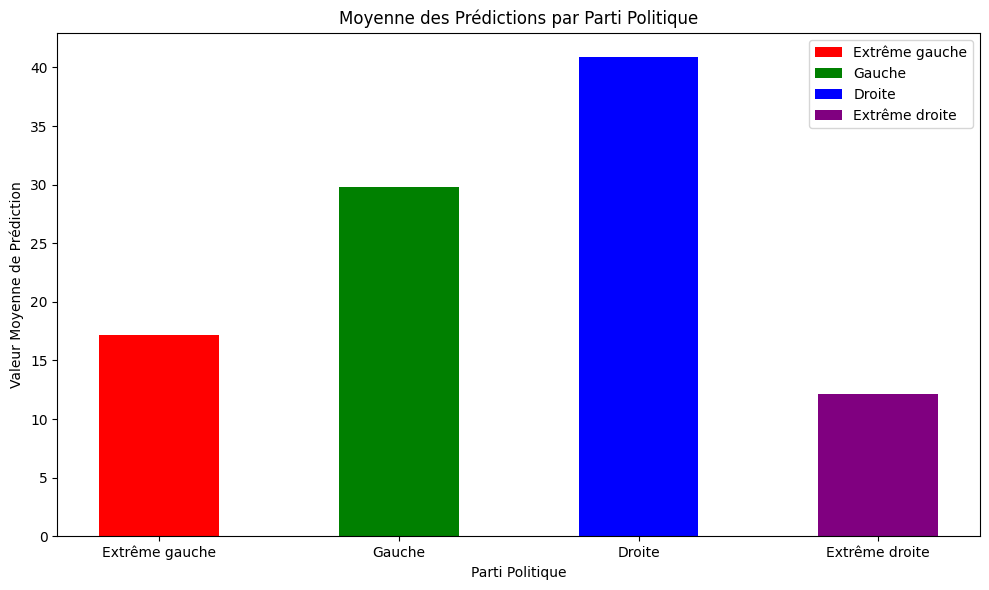

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Noms des partis politiques correspondant à chaque colonne dans y_pred
partis_politiques = ["Extrême gauche", "Gauche", "Droite", "Extrême droite"]

# Couleurs spécifiques pour les prédictions de chaque parti politique
parties_colors = {
    'Extrême gauche': 'red',
    'Gauche': 'green',
    'Droite': 'blue',
    'Extrême droite': 'purple'
}

# Assurez-vous que y_pred est un tableau numpy
y_pred = np.array(y_pred)

# Calculer la moyenne des prédictions pour chaque parti politique
mean_predictions = [np.mean(y_pred[:, i]) for i in range(y_pred.shape[1])]

# Créer un graphique avec une barre pour chaque parti politique
plt.figure(figsize=(10, 6))
index = np.arange(len(partis_politiques))  # Indices pour les barres
bar_width = 0.5  # Largeur des barres

# Créer des barres pour chaque parti politique
for i, parti in enumerate(partis_politiques):
    plt.bar(index[i], mean_predictions[i], bar_width, label=parti, color=parties_colors[parti])

plt.xlabel('Parti Politique')
plt.ylabel('Valeur Moyenne de Prédiction')
plt.title('Moyenne des Prédictions par Parti Politique')
plt.xticks(index, partis_politiques)  # Étiquettes des partis sous chaque barre
plt.legend()

plt.tight_layout()
plt.show()


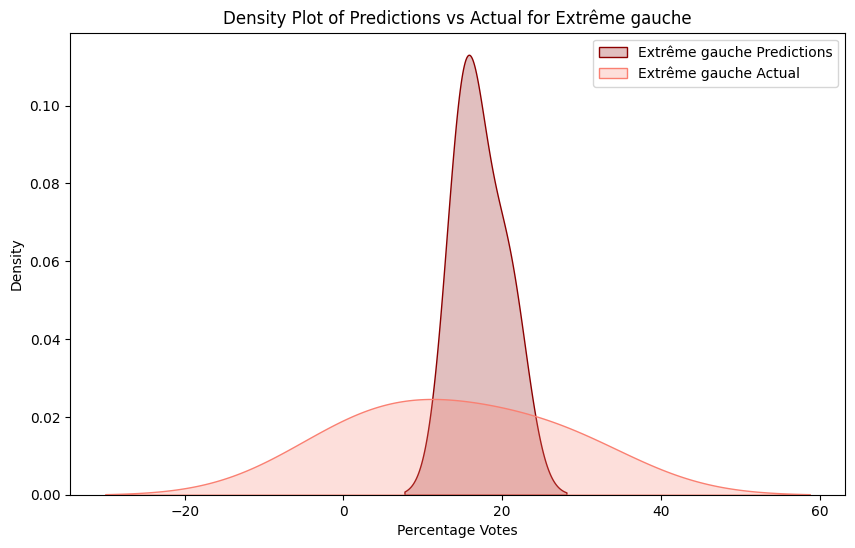

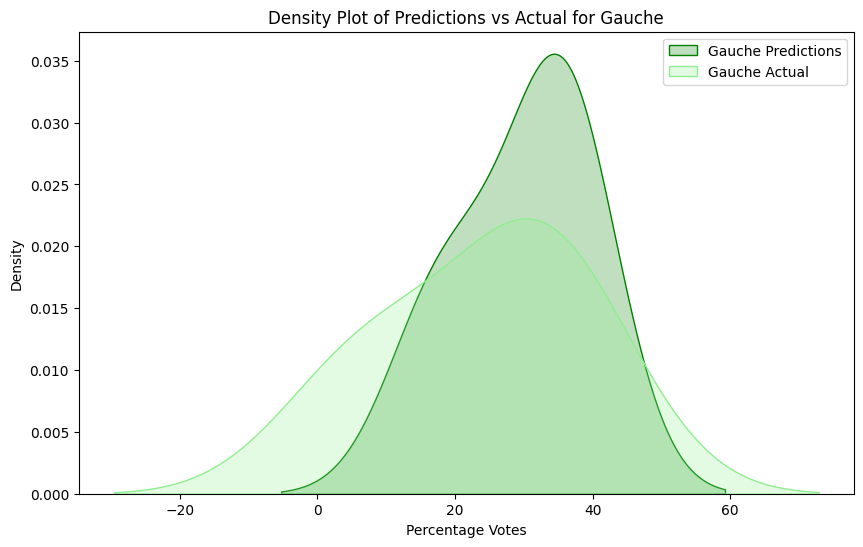

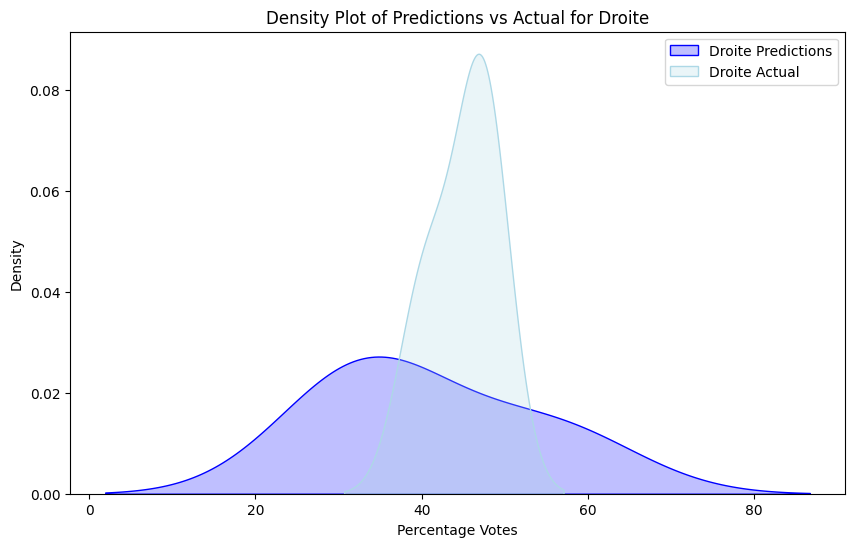

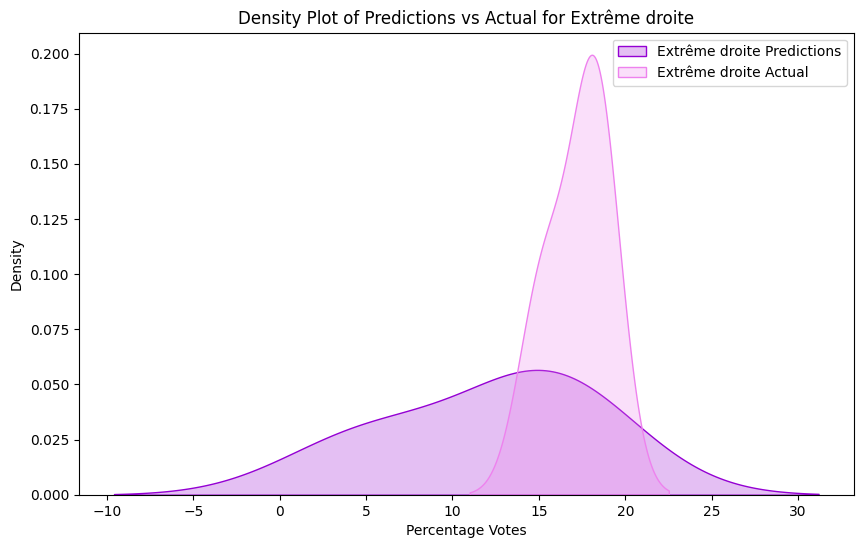

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

y_pred_df = pd.DataFrame(y_pred, columns=["Extrême gauche", "Gauche", "Droite", "Extrême droite"])
y_test_df = pd.DataFrame(y_test, columns=["Extrême gauche", "Gauche", "Droite", "Extrême droite"])

colors = {
    "Extrême gauche": ("darkred", "salmon"),
    "Gauche": ("green", "lightgreen"),
    "Droite": ("blue", "lightblue"),
    "Extrême droite": ("darkviolet", "violet")
}

for party in ["Extrême gauche", "Gauche", "Droite", "Extrême droite"]:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(y_pred_df[party], color=colors[party][0], label=f'{party} Predictions', fill=True)
    sns.kdeplot(y_test_df[party], color=colors[party][1], label=f'{party} Actual', fill=True)
    plt.title(f'Density Plot of Predictions vs Actual for {party}')
    plt.xlabel('Percentage Votes')
    plt.ylabel('Density')
    plt.legend()
    plt.show()



# Nombre d'occurence : 

In [95]:
# Afficher le nombre d'estimators configuré dans RandomForestClassifier et RandomForestRegressor
print("Nombre d'arbres dans RandomForestClassifier:", classifier.n_estimators)
print("Nombre d'arbres dans RandomForestRegressor:", regressor.n_estimators)


Nombre d'arbres dans RandomForestClassifier: 200
Nombre d'arbres dans RandomForestRegressor: 100


# Export du dataset de résultat

In [96]:
import pandas as pd

# Supposons que vous ayez déjà calculé les précisions et les importances des caractéristiques
accuracies = [accuracy_score(y_test_class.iloc[:, i], y_pred_class[:, i]) for i in range(y_test_class.shape[1])]
feature_importances = regressor.feature_importances_
mse = mean_squared_error(y_test, y_pred_regressor)

# Création d'un DataFrame avec ces résultats
results = pd.DataFrame({
    'Extrême gauche': accuracies[0],
    'Gauche': accuracies[1],
    'Droite': accuracies[2],
    'Extrême droite': accuracies[3],
    'Importance Chômage': feature_importances[0],
    'Importance Pouvoir d’achat 1': feature_importances[1],
    'Importance Pouvoir d’achat 2': feature_importances[2]
}, index=[0])  # Index 0 pour indiquer une seule ligne de résultats

# Afficher les résultats
print(results)

# Enregistrement des résultats dans un fichier CSV
results.to_csv('../dataset/results.csv', index=False,encoding='utf-8-sig')


   Extrême gauche    Gauche    Droite  Extrême droite  Importance Chômage  \
0        0.666667  0.333333  0.666667             1.0            0.341114   

   Importance Pouvoir d’achat 1  Importance Pouvoir d’achat 2  
0                      0.304567                      0.354319  
